In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [405]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_11b511ecdded45f1a1bc08926e18eefd = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='YyghOkiy75jt8oUwfbu9oEoIZclmjgxc_S1Vc0LSzRqZ',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu.cloud-object-storage.appdomain.cloud')

body = client_11b511ecdded45f1a1bc08926e18eefd.get_object(Bucket='forecastingpriceofafuel-donotdelete-pr-79ogxvjhd26a5w',Key='Crude Oil Prices Daily.xlsx')['Body']

data = pd.read_excel(body.read())
data.head()


,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [406]:
data.tail()

,Date,Closing Value
8218,2018-07-03,74.19
8219,2018-07-04,NaN
8220,2018-07-05,73.05
8221,2018-07-06,73.78
8222,2018-07-09,73.93


In [407]:
data.describe()

,Closing Value
count,8216.000000
mean,43.492139
std,29.616804
min,10.250000
25%,19.577500
50%,29.610000
75%,63.402500
max,145.310000


In [408]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8223 entries, 0 to 8222
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           8223 non-null   datetime64[ns]
 1   Closing Value  8216 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.6 KB


### Data preprocessing

In [409]:
data.isnull().any()

Date             False
Closing Value     True
dtype: bool

In [410]:
data.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [411]:
data.dropna(axis=0,inplace=True)

In [412]:
data.isnull().sum()

Date             0
Closing Value    0
dtype: int64

In [413]:
data.shape

(8216, 2)

In [414]:
import tensorflow as tf

In [415]:
tf.__version__

'2.7.0'

In [416]:
import tensorflow.keras

In [417]:
tensorflow.keras.__version__

'2.7.0'

In [418]:
data_oil=data.reset_index()['Closing Value']

In [419]:
data_oil

0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8211    73.89
8212    74.19
8213    73.05
8214    73.78
8215    73.93
Name: Closing Value, Length: 8216, dtype: float64

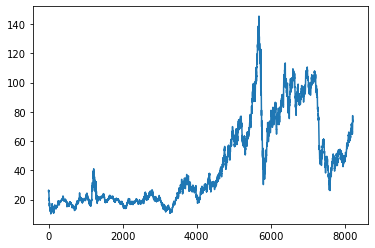

In [420]:
plt.plot(data_oil)

In [421]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
#Featuring Scaling
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data_oil=scaler.fit_transform(np.array(data_oil).reshape(-1,1))

In [422]:
print(data_oil)

[[0.11335703]
 [0.11661484]
 [0.12053902]
 ...
 [0.46497853]
 [0.47038353]
 [0.47149415]]


### Splitting data set into train and test

In [423]:
training_size=int(len(data_oil)*0.65)
test_size=len(data_oil)-training_size
train_data,test_data=data_oil[0:training_size,:],data_oil[training_size:len(data_oil),:1]

In [424]:
training_size,test_size

(5340, 2876)

In [425]:
train_data

array([[0.11335703],
       [0.11661484],
       [0.12053902],
       ...,
       [0.37916482],
       [0.38153413],
       [0.38294092]])

In [426]:
train_data.shape

(5340, 1)

In [427]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [428]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [429]:
print(X_train.shape), print(y_train.shape)

(5329, 10)
(5329,)


(None, None)

In [430]:
print(X_test.shape), print(ytest.shape)

(2865, 10)
(2865,)


(None, None)

In [431]:
X_train

array([[0.11335703, 0.11661484, 0.12053902, ..., 0.10980305, 0.1089886 ,
        0.11054346],
       [0.11661484, 0.12053902, 0.11550422, ..., 0.1089886 , 0.11054346,
        0.10165852],
       [0.12053902, 0.11550422, 0.1156523 , ..., 0.11054346, 0.10165852,
        0.09906708],
       ...,
       [0.36731823, 0.35176958, 0.36080261, ..., 0.36391234, 0.37042796,
        0.37042796],
       [0.35176958, 0.36080261, 0.35354657, ..., 0.37042796, 0.37042796,
        0.37879461],
       [0.36080261, 0.35354657, 0.35295424, ..., 0.37042796, 0.37879461,
        0.37916482]])

In [432]:
y_train

array([0.10165852, 0.09906708, 0.08203761, ..., 0.37879461, 0.37916482,
       0.38153413])

In [433]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Create the stacked LSTM model

In [434]:
#tensorflow :open source used for both ML and DL for computation
from tensorflow.keras.models import Sequential#it is a plain stack of layers
from tensorflow.keras.layers import Dense#Dense layer is the regular deeply connected neural network layer
from tensorflow.keras.layers import LSTM #Long Short Trem Memory

In [435]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [436]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_22 (LSTM)              (None, 10, 50)            20200     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [437]:
#Training the model
model1.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
84/84 [==============================] - 8s 95ms/step - loss: 3.2858e-05 - val_loss: 5.0794e-04
Epoch 2/50
84/84 [==============================] - 8s 97ms/step - loss: 3.1395e-05 - val_loss: 2.2573e-04
Epoch 3/50
84/84 [==============================] - 8s 98ms/step - loss: 3.3927e-05 - val_loss: 1.7283e-04
Epoch 4/50
84/84 [==============================] - 8s 98ms/step - loss: 3.4213e-05 - val_loss: 2.2663e-04
Epoch 5/50
84/84 [==============================] - 8s 97ms/step - loss: 3.2589e-05 - val_loss: 1.7742e-04
Epoch 6/50
84/84 [==============================] - 8s 96ms/step - loss: 3.1046e-05 - val_loss: 1.7759e-04
Epoch 7/50
84/84 [==============================] - 8s 98ms/step - loss: 3.2753e-05 - val_loss: 2.4804e-04
Epoch 8/50
84/84 [==============================] - 8s 98ms/step - loss: 3.2086e-05 - val_loss: 1.7100e-04
Epoch 9/50
84/84 [==============================] - 8s 101ms/step - loss: 2.9968e-05 - val_loss: 1.9378e-04
Epoch 10/50
84/84 [=================

In [438]:
## Lets Do the prediction and check performance metrics
train_predict=model1.predict(X_train)
test_predict=model1.predict(X_test)

In [439]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Model evaluation

In [440]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

29.63598957222602

In [441]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

78.8658262768625

### Plot output

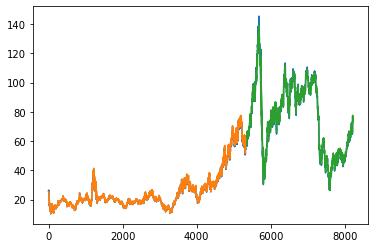

In [442]:
### Plotting 
# shift train predictions for plotting
look_back=10
trainPredictPlot = np.empty_like(data_oil)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data_oil)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data_oil)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_oil))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [443]:
import pickle
filehandler = open(b"crude.pickle","wb")
pickle.dump("artifact_content.tar",filehandler)
model.save("crude_oil.h5")

In [444]:
#prediction for next 10 days

In [445]:
len(test_data)

2876

In [446]:
x_input=test_data[2866:].reshape(1,-1)
x_input.shape

(1, 10)

In [447]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [448]:
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [449]:
len(temp_input)

10

### Predict future 10 days

In [450]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=10
i=0
while(i<10):
    
    if(len(temp_input)>10):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

print(lst_output)

[-0.02507537]
11
1 day input [ 0.4811195   0.49726048  0.46794017  0.47297497  0.47119799  0.47341922
  0.46497853  0.47038353  0.47149415 -0.02507537]
1 day output [[-0.02444387]]
2 day input [ 0.49726048  0.46794017  0.47297497  0.47119799  0.47341922  0.46497853
  0.47038353  0.47149415 -0.02507537 -0.02444387]
2 day output [[-0.02268571]]
3 day input [ 0.46794017  0.47297497  0.47119799  0.47341922  0.46497853  0.47038353
  0.47149415 -0.02507537 -0.02444387 -0.02268571]
3 day output [[-0.02004325]]
4 day input [ 0.47297497  0.47119799  0.47341922  0.46497853  0.47038353  0.47149415
 -0.02507537 -0.02444387 -0.02268571 -0.02004325]
4 day output [[-0.01697176]]
5 day input [ 0.47119799  0.47341922  0.46497853  0.47038353  0.47149415 -0.02507537
 -0.02444387 -0.02268571 -0.02004325 -0.01697176]
5 day output [[-0.0135904]]
6 day input [ 0.47341922  0.46497853  0.47038353  0.47149415 -0.02507537 -0.02444387
 -0.02268571 -0.02004325 -0.01697176 -0.0135904 ]
6 day output [[-0.01018248]]


In [451]:
day_new=np.arange(1,11)
day_pred=np.arange(11,21)

In [452]:
len(data_oil)

8216

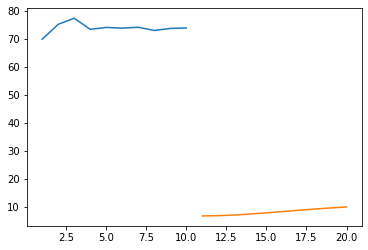

In [453]:
plt.plot(day_new,scaler.inverse_transform(data_oil[8206:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

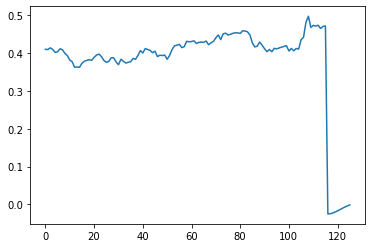

In [454]:
df3=data_oil.tolist()
df3.extend(lst_output)
plt.plot(df3[8100:])

In [455]:
df3=scaler.inverse_transform(df3).tolist()

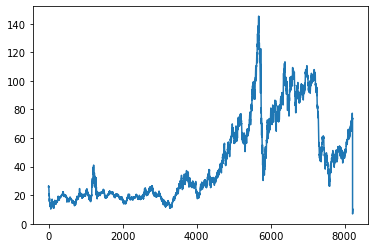

In [456]:
plt.plot(df3)

In [457]:
!pip install ibm_watson_machine_learning

In [458]:
import ibm_watson_machine_learning
import json
import numpy as np

### Authenticating and setting space

In [459]:
wml_credentials = { 
    "url": "https://eu-gb.ml.cloud.ibm.com",
    "apikey": "y7CP7GJbrDD2gSAPHP2_dk5JuC_8XpFjw4LZDjomnl9Y"
                  }

In [460]:
#Checking for available space
wml_client = APIClient(wml_credentials)
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ---------------  ------------------------
ID                                    NAME             CREATED
0175d17e-36a9-4c2c-aa1f-cdc234d039da  fuel_deployment  2022-04-03T09:41:25.109Z
------------------------------------  ---------------  ------------------------


In [461]:
SPACE_ID = "0175d17e-36a9-4c2c-aa1f-cdc234d039da"

In [462]:
#setting space in default
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

### Saving and deploying the model

In [463]:
MODEL_NAME = "fuel_price"
DEPLOYMENT_NAME = "fuel_deployment"
BEST_MODEL = model

In [464]:
#setting python version
software_spec_uid = wml_client.software_specifications.get_id_by_name("default_py3.8")

In [465]:
#setup model meta-model properties
model_props = {
    wml_client.repository.ModelMetaNames.NAME:MODEL_NAME,
    wml_client.repository.ModelMetaNames.TYPE:'Tensorflow_2.4',
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid
}

In [466]:
#saving the model
!tar -zcvf Crudeoil1.tgz crude_oil.h5
model_details = wml_client.repository.store_model(
    model = 'Crudeoil1.tgz',
    meta_props = model_props,
    training_data = X_train,
    training_target = y_train,
)

crude_oil.h5
Note: Warnings!! :  Software specification default_py3.8 specified for the wml_model is deprecated and will be removed in the future. We recommend you use runtime-22.1-py3.9 instead. For details see Supported Frameworks https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html


In [467]:
software_spec_uid

'ab9e1b80-f2ce-592c-a7d2-4f2344f77194'

In [468]:
model_uid = wml_client.repository.get_model_id(model_details)
model_uid

'a50807dd-c10c-495c-b57c-f656c3e338b8'

### Deploying the model in IBM

In [469]:
#set meta
deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME,
    wml_client.deployments.ConfigurationMetaNames.ONLINE:{}
}

In [470]:
deployment = wml_client.deployments.create(artifact_uid = model_uid, meta_props = deployment_props)



#######################################################################################

Synchronous deployment creation for uid: 'a50807dd-c10c-495c-b57c-f656c3e338b8' started

#######################################################################################


initializing
Note: Software specifications default_py3.8, tensorflow_2.4-py3.8, tensorflow_2.4-py3.8-horovod  are deprecated. Use runtime-22.1-py3.9 or tensorflow_rt22.1-py3.9 or tensorflow_rt22.1-py3.9-horovod  software specification instead. For details, see https://dataplatform.cloud.ibm.com/docs/content/wsj/wmls/wmls-deploy-python-types.html?context=cpdaas.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ae77574c-5218-4eb0-a84e-e70ce39b8af2'
------------------------------------------------------------------------------------------------




In [472]:
deployment_uid = wml_client.deployments.get_uid(deployment)
deployment_uid

'ae77574c-5218-4eb0-a84e-e70ce39b8af2'

In [479]:
payload = {"input_data": [{"fields": [["Closing Value"]], "values": [x_input.tolist()]}]}

In [ ]:
result = wml_client.deployments.score(deployment_uid,payload)